In [1]:
import numpy as np
from scipy.stats import truncnorm
def truncated_normal(mean=0, sd=1, low=0, upp=10):
  return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
@np.vectorize
def sigmoid(x):
  return 1 / (1 + np.e ** -x)
def softmax(x):
  e_x = np.exp(x)
  return e_x / e_x.sum()


In [2]:
class NeuralNetwork:
  def __init__(self,no_of_in_nodes,no_of_out_nodes,no_of_hidden_nodes,learning_rate,softmax=True):
    self.no_of_in_nodes = no_of_in_nodes
    self.no_of_out_nodes = no_of_out_nodes
    self.no_of_hidden_nodes = no_of_hidden_nodes
    self.learning_rate = learning_rate
    self.softmax = softmax
    self.create_weight_matrices()

  def create_weight_matrices(self):
      rad = 1 / np.sqrt(self.no_of_in_nodes)
      X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
      self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes,self.no_of_in_nodes))
      rad = 1 / np.sqrt(self.no_of_hidden_nodes)
      X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
      self.weights_hidden_out = X.rvs((self.no_of_out_nodes,self.no_of_hidden_nodes))

  def train(self, input_vector, target_vector):
    input_vector = np.array(input_vector)
    input_vector = input_vector.reshape(input_vector.size, 1)
    target_vector = np.array(target_vector).reshape(target_vector.size, 1)
    output_vector_hidden = sigmoid(self.weights_in_hidden @ input_vector)
    if self.softmax:
      output_vector_network = softmax(self.weights_hidden_out @ output_vector_hidden)
    else:
      output_vector_network = sigmoid(self.weights_hidden_out @ output_vector_hidden)
    output_error = target_vector - output_vector_network
    if self.softmax:
      ovn = output_vector_network.reshape(output_vector_network.size,)
      si_sj = - ovn * ovn.reshape(self.no_of_out_nodes, 1)
      s_der = np.diag(ovn) + si_sj
      tmp = s_der @ output_error
      self.weights_hidden_out += self.learning_rate * (tmp @ output_vector_hidden.T)
    else:
      tmp = output_error * output_vector_network * (1.0 - output_vector_network)
      self.weights_hidden_out += self.learning_rate * (tmp @ output_vector_hidden.T)
    hidden_errors = self.weights_hidden_out.T @ output_error
    tmp = hidden_errors * output_vector_hidden * (1.0 - output_vector_hidden)
    self.weights_in_hidden += self.learning_rate * (tmp @ input_vector.T)

  def run(self, input_vector):
    input_vector = np.array(input_vector)
    input_vector = input_vector.reshape(input_vector.size, 1)
    input4hidden = sigmoid(self.weights_in_hidden @ input_vector)

    if self.softmax:
        output_vector_network = softmax(self.weights_hidden_out @ input4hidden)
    else:
        output_vector_network = sigmoid(self.weights_hidden_out @ input4hidden)

    return output_vector_network

  def evaluate(self, data, labels):
    corrects, wrongs = 0, 0
    for i in range(len(data)):
      res = self.run(data[i])
      res_max = res.argmax()
      if res_max == labels[i]:
        corrects += 1
      else:
        wrongs += 1
    return corrects, wrongs



In [3]:
from sklearn.datasets import make_blobs

n_samples = 300
samples, labels = make_blobs(n_samples=n_samples,centers=([2, 6], [6, 2]),random_state=0)

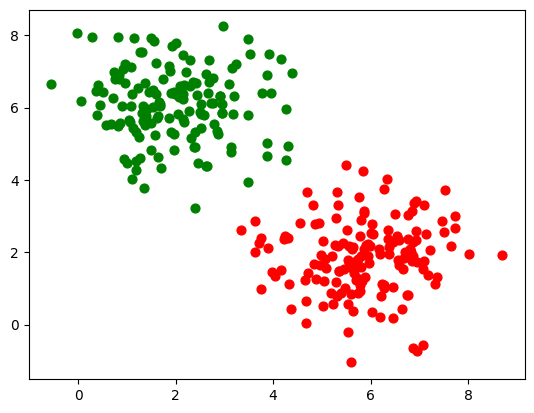

In [4]:
import matplotlib.pyplot as plt
colours = ('green', 'red', 'blue', 'magenta', 'yellow', 'cyan')
fig, ax = plt.subplots()

for n_class in range(2):
  ax.scatter(samples[labels==n_class][:, 0], samples[labels==n_class][:, 1],c=colours[n_class], s=40, label=str(n_class))
size_of_learn_sample = int(n_samples * 0.8)

learn_data = samples[:size_of_learn_sample]
test_data = samples[-size_of_learn_sample:]
